loading data for bg done (1/21)
loading data for cs done (2/21)
loading data for da done (3/21)
loading data for de done (4/21)
loading data for el done (5/21)
loading data for en done (6/21)
loading data for es done (7/21)
loading data for et done (8/21)
loading data for fi done (9/21)
loading data for fr done (10/21)
loading data for hu done (11/21)
loading data for it done (12/21)
loading data for lt done (13/21)
loading data for lv done (14/21)
loading data for nl done (15/21)
loading data for pl done (16/21)
loading data for pt done (17/21)
loading data for ro done (18/21)
loading data for sk done (19/21)
loading data for sl done (20/21)
loading data for sv done (21/21)
loading data took 119.90171408653259 seconds
Accuracy:  0.46
F1 score:  0.4456647465260946


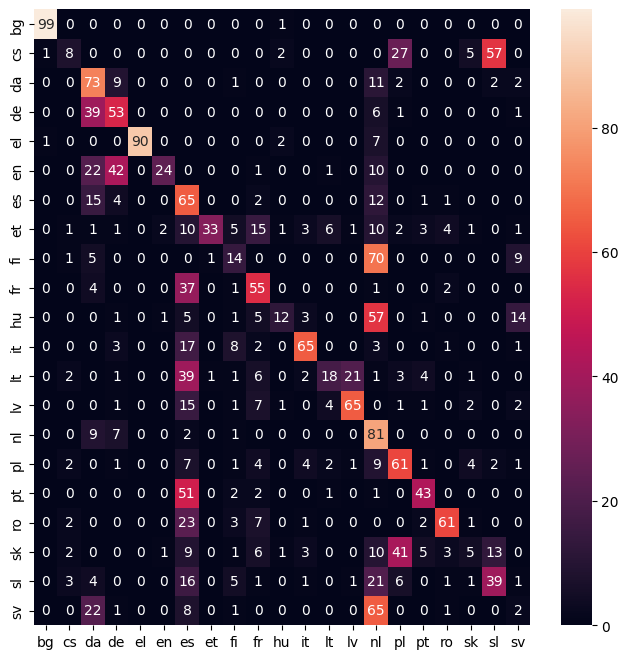

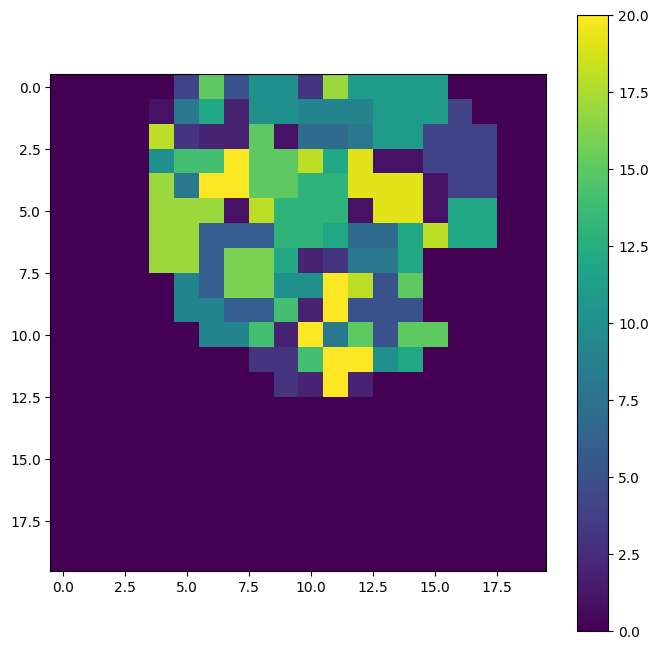

In [28]:
import re
import time
import string
# pip install nltk
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
import numpy as np
# pip install matplotlib
import matplotlib.pyplot as plt
# pip install susi
import susi
# pip install -U scikit-learn
import sklearn.metrics
import pandas as pd
# pip install seaborn
import seaborn as sn
from sklearn_som.som import SOM


d = 1000
H = {}
s = {}
s_test = {}
n = 3
rows = 20
columns = 20
languages = 21
sigma = 1
epochs = 3
np.random.seed(42)
test_size = 100
language_codes = ['bg', 'cs',  'da', 'de', 'el', 'en', 'es', 'et', 'fi', 'fr', 'hu', 'it', 'lt', 'lv', 'nl', 'pl', 'pt', 'ro', 'sk', 'sl', 'sv']
permutation = np.random.permutation(d)
training_path = 'data/training/'
test_path = 'data/test/'
X_train = np.empty((220000, d))
X_test = np.empty((220000, d))
Y_train = np.empty((220000, ))
Y_test = np.empty((220000, ))

H_n_gram = {}
# Function to generate n-grams from a sentence
def generate_ngrams(text):
    # Generate n-grams
    n_grams = list(ngrams(list(text), n))
    
    return n_grams
    
def bind(H1, H2):
    return np.multiply(H1, H2)

def permute(H, r):
    for _ in range(r):
        H = H[permutation]
    return H

def bundle(H1, H2):
    return H1 + H2
    
def generate_hd_vector_letter():
    return np.random.choice([-1, 1], size = d)

def generate_hd_vector_n_gram(n_gram):
    if n_gram in H_n_gram:
        return H_n_gram[n_gram]
        
    result = np.ones(d)
    for i in range(n):
        result = bind(permute(H[n_gram[i]], i + 1), result)
    H_n_gram[n_gram] = result
    return result

def normalize(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    normalized_array = -1 + 2 * (arr - min_val) / (max_val - min_val)
    return normalized_array
    
def generate_hd_vector_text(n_grams, scope):  
    n_grams = set(n_grams)
    result = np.zeros(d)
    for n_gram in n_grams:
        rep = s[n_gram] if scope == 'train' else s_test[n_gram]
        result += rep * generate_hd_vector_n_gram(n_gram)

    return normalize(result)

def preprocess_text(text):
    # Convert the text to lowercase
    text = text.lower()
    
    # Remove non-alphabetic characters (except spaces)
    text = ''.join(char if char.isalpha() or char.isspace() else ' ' for char in text)
    
    # Remove extra spaces
    text = ' '.join(text.split())
    
    return text
    
ind_train = 0
ind_test = 0
def load_training_data(file_path, ind):
    global X_train, Y_train, ind_train
    i = 0
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            
            # Split the line into number and sentence
            parts = line.strip().split('\t', 1)
            if len(parts) == 2:
                _, text = parts
                text = preprocess_text(text)
                for letter in text:
                    if not letter in H:
                        H[letter] = generate_hd_vector_letter()  
                n_grams = generate_ngrams(text)
                for n_gram in n_grams:
                    if n_gram in s:
                        s[n_gram] += 1
                    else:
                        s[n_gram] = 1    
                X_train[ind_train] = generate_hd_vector_text(n_grams, 'train')
                Y_train[ind_train] = ind   
                for n_gram in n_grams:
                    s[n_gram] = 0
                ind_train += 1
                        
def load_test_data(file_path, ind):
    global X_test, Y_test, ind_test
    i = 0
    with open(file_path, 'r', encoding='utf-8') as file:
        for text in file:
            if text[0] != '<':
                text = preprocess_text(text)
                for letter in text:
                    if not letter in H:
                        H[letter] = generate_hd_vector_letter()  
                n_grams = generate_ngrams(text)
                for n_gram in n_grams:
                    if n_gram in s_test:
                        s_test[n_gram] += 1
                    else:
                        s_test[n_gram] = 1    
                X_test[ind_test] = generate_hd_vector_text(n_grams, 'test')
                Y_test[ind_test] = ind
                for n_gram in n_grams:
                    s[n_gram] = 0
                ind_test += 1
                i += 1
                if i==test_size:
                    break
    
start_time = time.time()

language_codes = language_codes[0:languages]
for i in range(len(language_codes)):
    load_training_data(f"{training_path}/{language_codes[i]}.txt", i)
    load_test_data(f"{test_path}/{language_codes[i]}.txt", i)
    print(f"loading data for {language_codes[i]} done ({i+1}/{len(language_codes)})")
    
train_permutation = np.random.permutation(ind_train)
test_permutation = np.random.permutation(ind_test)

X_train = X_train[0:ind_train][train_permutation]
Y_train = Y_train[0:ind_train][train_permutation]
X_test = X_test[0:ind_test][test_permutation]
Y_test = Y_test[0:ind_test][test_permutation]

end_time = time.time()
print(f"loading data took {end_time - start_time} seconds")

som = SOM(m=columns, n=rows, dim=d)
som.random_state = 55
som.sigma = sigma
som.fit(X_train, epochs = epochs)
predictions = som.predict(X_test)

stats = np.zeros((columns*rows, 21))

for i in range(len(X_train)):
    x = X_train[i]
    y = int(Y_train[i])
    node = som._find_bmu(x)
    stats[node][y] += 1

label = [np.argmax(node) for node in stats]
y_pred = [label[p] for p in predictions]
print("Accuracy: ", np.sum(y_pred == Y_test)/len(y_pred))


#F1 score
print("F1 score: ", sklearn.metrics.f1_score(Y_test, y_pred, average = 'weighted'))

conf_mat= sklearn.metrics.confusion_matrix(Y_test, y_pred, labels=None, sample_weight=None)

#plot confusion matrix
df_cm = pd.DataFrame(conf_mat, index = [i for i in language_codes], columns = [j for j in language_codes])
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)

plt.figure(figsize = (8,8))

data_2d = np.array(label).reshape(rows, columns)
plt.imshow(data_2d, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()